# Multi-layer Perceptron
Test code same as RNAlight and LightGBM

See RNAlight_127, RF_201

In [18]:
import time
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())

2024-03-21 20:45:23.785998
Python 3.10.12


In [19]:
import os
import copy
import random
import collections
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import warnings
import sklearn
import joblib
print('sklearn',sklearn.__version__)
print('Done')

sklearn 1.2.2
Done


In [20]:
SEED = 100
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.backend.set_floatx('float32')
print(SEED)

100


In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
print('Done')

Done


In [22]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
print('Done')

Done


In [23]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [24]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/RNAlight/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/RNAlight/'  # must end in "/"
    output_dir=PATH+'My Drive/data/Localization/RNAlight/'
except:
    IN_COLAB = False
    DATA_DIR = './'    # Mac
    MODEL_DIR = './'    # Mac
    output_dir = './'
print('DATA DIR', DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
DATA DIR /content/drive/My Drive/data/Localization/RNAlight/


In [25]:
def build_model():
    SHAPE = 1344   # empirically from array of k-mer profiles
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype='float32',input_dim=SHAPE)  # input_dim to be determined
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [26]:
test = build_model()
print(test)
test = None

In [27]:
class stats_collector:
    def __init__(self):
        self.reset_statistics()
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_mcc=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
    def _append_statistics(self,accuracy,precision,recall,f1,mcc,auprc,auroc):
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)
    def compute_performance(self,y_test,yhat_pred,yhat_classes,verbose=False):
        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        self._append_statistics(accuracy,precision,recall,f1,mcc,auprc,auroc)
        if verbose:
            self._show_confusion(y_test,yhat_pred,yhat_classes)
            self._show_statistics(accuracy,precision,recall,f1,mcc,auprc,auroc)
    def _show_confusion(self,y_test,yhat_pred,yhat_classes):
            print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            cm1 = confusion_matrix(y_test,yhat_classes)
            print('Confusion matrix\n',cm1)
            cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
            print('Normalized matrix\n',cm2)
    def _show_statistics(self,accuracy,precision,recall,f1,mcc,auprc,auroc):
            print('accuracy:',accuracy,'precision:',precision,'recall:',recall,\
                  'F1:',f1,'MCC:',mcc,'AUPRC:',auprc,'AUROC:',auroc)
    def _show_variance(self, name, stats_list):
        if name=='MCC':
            print('%10s %5.3f mean, %6.3f stdev' % (name,np.mean(stats_list),np.std(stats_list) ) )
        else:
            print('%10s %5.2f mean, %6.3f stdev' % (name,np.mean(stats_list),np.std(stats_list) ) )
        print(stats_list)
    def dump_all(self):
        self._show_variance('accuracy', self.cv_accuracy)
        self._show_variance('precision',self.cv_precision)
        self._show_variance('recall',   self.cv_recall)
        self._show_variance('F1',       self.cv_f1)
        self._show_variance('MCC',      self.cv_mcc)
        self._show_variance('AUPRC',    self.cv_auprc)
        self._show_variance('AUROC',    self.cv_auroc)

In [28]:
# From RNAlight notebook
def _count_kmer(Dataset,k): # k = 3,4,5

    # copy dataset
    dataset = copy.deepcopy(Dataset)
    # alphbet of nucleotide
    nucleotide = ['A','C','G','T']

    # generate k-mers
    #  k == 5:
    five = list(itertools.product(nucleotide,repeat=5))
    pentamer = []
    for n in five:
        pentamer.append("".join(n))

    #  k == 4:
    four = list(itertools.product(nucleotide,repeat=4))
    tetramer = []
    for n in four:
        tetramer.append("".join(n))

    # k == 3:
    three = list(itertools.product(nucleotide,repeat=3))
    threemer = []
    for n in three:
        threemer.append("".join(n))

    # input features can be combinations of diffrent k values
    if k == 34:
        table_kmer = dict.fromkeys(threemer,0)
        table_kmer.update(dict.fromkeys(tetramer,0))
    if k == 45:
        table_kmer = dict.fromkeys(tetramer,0)
        table_kmer.update(dict.fromkeys(pentamer,0))
    if k == 345:
        table_kmer = dict.fromkeys(threemer,0)
        table_kmer.update(dict.fromkeys(tetramer,0))
        table_kmer.update(dict.fromkeys(pentamer,0))

    # count k-mer for each sequence
    for mer in table_kmer.keys():
        table_kmer[mer] = dataset["cdna"].apply(lambda x : x.count(mer))

    # for k-mer raw count without normalization, index: nuc:1 or cyto:0
    rawcount_kmer_df = pd.DataFrame(table_kmer)
    df1_rawcount = pd.concat([rawcount_kmer_df,dataset["ensembl_transcript_id"]],axis = 1)
    df1_rawcount.index = dataset["tag"]

    # for k-mer frequency with normalization , index: nuc:1 or cyto:0
    freq_kmer_df = rawcount_kmer_df.apply(lambda x: x/x.sum(),axis=1)
    df1 = pd.concat([freq_kmer_df,dataset["ensembl_transcript_id"]],axis = 1)
    df1.index = dataset["tag"]

    return df1  # ,df1_rawcount

In [29]:
# From RNAlight notebook
def load_dataframe(cyto_f,nuc_f,cyto_mid_f,nuc_mid_f):
    print('load dataframe')
    dataset_cyto = pd.read_csv(cyto_f,sep='\t',index_col = False)
    dataset_nuc = pd.read_csv(nuc_f,sep='\t',index_col = False)
    print( len(dataset_cyto), 'cytoplasmic samples')
    print( len(dataset_nuc),  'nuclear samples')
    middle_cyto = pd.read_csv(cyto_mid_f,sep='\t',index_col = False)
    middle_nuc = pd.read_csv(nuc_mid_f,sep='\t',index_col = False)
    print( len(middle_cyto), 'cytoplasmic middle samples')
    print( len(middle_nuc),  'nuclear middle samples')
    return dataset_cyto,dataset_nuc,middle_cyto,middle_nuc

In [30]:
# Added
def rebalance(dataset_cyto,dataset_nuc):
    print('sample down to balance classes')
    min_size = min(len(dataset_cyto),len(dataset_nuc))
    # random sampling without replacement
    dataset_cyto = dataset_cyto.sample(min_size, random_state=SEED)
    dataset_nuc  = dataset_nuc.sample(min_size,  random_state=SEED)
    print( len(dataset_cyto), 'cytoplasmic samples')
    print( len(dataset_nuc),  'nuclear samples')
    return dataset_cyto,dataset_nuc

In [31]:
PERMANENT_NUC = 1
PERMANENT_CYTO = 0
INDICATOR_NUC = 2
INDICATOR_CYTO = -2
# From RNAlight notebook
def extract_features_and_split(dataset_cyto,dataset_nuc,middle_cyto,middle_nuc):
    print('add labels, concatenate')
    # Set the tag of RCI(log2FC): nuclear 1 / cytosol 0
    #dataset_nuc['tag'] = 1;dataset_cyto['tag'] = 0
    dataset_nuc['tag'] = PERMANENT_NUC;dataset_cyto['tag'] = PERMANENT_CYTO
    middle_nuc['tag'] = INDICATOR_NUC;middle_cyto['tag'] = INDICATOR_CYTO
    # merge the datasets
    dataset = pd.concat([dataset_nuc,dataset_cyto])
    dataset = pd.concat([dataset,middle_nuc])
    dataset = pd.concat([dataset,middle_cyto])

    print('dedupe (probably not necessary)')
    # remove duplications(actually,each lncRNA is unique in its class)
    dataset.drop_duplicates(keep="first",subset=["ensembl_transcript_id","name","cdna"],inplace=True)

    print('count kmers')
    # k = 3,4,5 count the normalized and raw count of kmer
    df_kmer_345 = _count_kmer(dataset,345)   # df_kmer_345,df_kmer_345_rawcount =

    # We commented this out. No need to save the tsv.
    # df_kmer_345.to_csv(os.path.join(output_dir,"df_kmer345_freq.tsv"),sep='\t')
    # This was commented out in the original. Seems they reran using saved kmers. Should test if file exists.
    # load kmer file
    # df_kmer_345 = pd.read_csv(os.path.join(output_dir,"df_kmer345_freq.tsv"),sep='\t',index_col= 0)

    # convert to x:kmer-freq , y:label
    del df_kmer_345['ensembl_transcript_id']
    x_kmer = df_kmer_345.values
    y_kmer = y_kmer = np.array(df_kmer_345.index)

    # split into training and test sets (9:1)
    print('train/test split')
    x_train, x_test, y_train, y_test = train_test_split(x_kmer, y_kmer, test_size = 0.1, random_state = SEED)

    #print('Apply cross-validation to all the data (no test set withheld)')
    #x_train, x_test, y_train, y_test = train_test_split(x_kmer, y_kmer, test_size = None, random_state = SEED)
    print('train set shape',x_train.shape)
    # Added
    labels,counts = np.unique(y_train,return_counts=True)
    print('train set labels', labels, 'counts',counts)
    labels,counts = np.unique(y_test,return_counts=True)
    print('test set labels', labels, 'counts',counts)
    return x_train, x_test, y_train, y_test

In [32]:
TRAIN_MODE='train'
VALID_MODE='valid'
def do_cv(x_train, y_train, exclusion_mode):
    stats = stats_collector()
    for round in range(1,3):   # RESTORE TO RANGE(1,3)
        fold=0
        splitter = KFold(n_splits=5)  # RESTORE TO SPLITS=5
        for train_index, valid_index in splitter.split(x_train):
            fold += 1
            print('Round', round, 'Fold', fold)
            print('Train')
            lgb = build_model()
            print('Num samples in training set:', len(x_train), len(y_train))
            x_reduced = x_train[train_index]
            y_reduced = y_train[train_index]
            print('Num train samples in this fold:', len(x_reduced), len(y_reduced))
            exclusions = []
            for i in range(len(y_reduced)):
                if y_reduced[i] == INDICATOR_NUC:
                    if exclusion_mode==TRAIN_MODE:
                        exclusions.append(i)
                    else:
                        y_reduced[i] = PERMANENT_NUC
                elif y_reduced[i] == INDICATOR_CYTO:
                    if exclusion_mode==TRAIN_MODE:
                        exclusions.append(i)
                    else:
                        y_reduced[i] = PERMANENT_CYTO
            print('Num exclusions:', len(exclusions))
            if len(exclusions)>0:
                x_reduced = np.delete(x_reduced,exclusions,axis=0)
                y_reduced = np.delete(y_reduced,exclusions,axis=0)
            print('Num train samples after exclusion:', len(x_reduced), len(y_reduced))
            history = lgb.fit(x_reduced, y_reduced,
                             epochs=150, verbose=0)  # RESTORE TO EPOCHS 300?
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print('Validate')
            x_reduced = x_train[valid_index]
            y_reduced = y_train[valid_index]
            print('Num validation samples in this fold:', len(x_reduced), len(y_reduced))
            exclusions = []
            for i in range(len(y_reduced)):
                if y_reduced[i] == INDICATOR_NUC:
                    if exclusion_mode==VALID_MODE:
                        exclusions.append(i)
                    else:
                        y_reduced[i] = PERMANENT_NUC
                elif y_reduced[i] == INDICATOR_CYTO:
                    if exclusion_mode==VALID_MODE:
                        exclusions.append(i)
                    else:
                        y_reduced[i] = PERMANENT_CYTO
            print('Num exclusions:', len(exclusions))
            if len(exclusions)>0:
                x_reduced = np.delete(x_reduced,exclusions,axis=0)
                y_reduced = np.delete(y_reduced,exclusions,axis=0)
            print('Num validation samples after exclusion:', len(x_reduced), len(y_reduced))
            yhat_pred=lgb.predict(x_reduced, verbose=0)
            yhat_classes=np.where(yhat_pred > 0.5, 1, 0)
            #yhat_classes= lgb.predict(x_valid)  # get 0 or 1
            #yhat_pairs=   lgb.predict_proba(x_valid)  # get [ prob of 0, prob of 1 ]
            #yhat_pred=    [pair[1] for pair in yhat_pairs]
            stats.compute_performance(y_reduced,yhat_pred,yhat_classes,verbose=False)
    return stats

middle exclusion on training set only
Data files:
/content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.lncRNA_RCIgt0.canonical.tsv 
 /content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.lncRNA_RCIlt-2.canonical.tsv
/content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.lncRNA_RCI-1to0.canonical.tsv 
 /content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.lncRNA_RCI-2to-1.canonical.tsv
load dataframe
1703 cytoplasmic samples
706 nuclear samples
1184 cytoplasmic middle samples
948 nuclear middle samples
Rebalance (sample down the majority class) and repeat
sample down to balance classes
706 cytoplasmic samples
706 nuclear samples
sample down to balance classes
948 cytoplasmic samples
948 nuclear samples
add labels, concatenate
dedupe (probably not necessary)
count kmers
train/test split
train set shape (2977, 1344)
train set labels [-2  0  1  2] counts [850 635 630 862]
test set labels [-2  0  1  2] counts [98 71 76 86]
Round 1 Fold 1
Train
Num samples

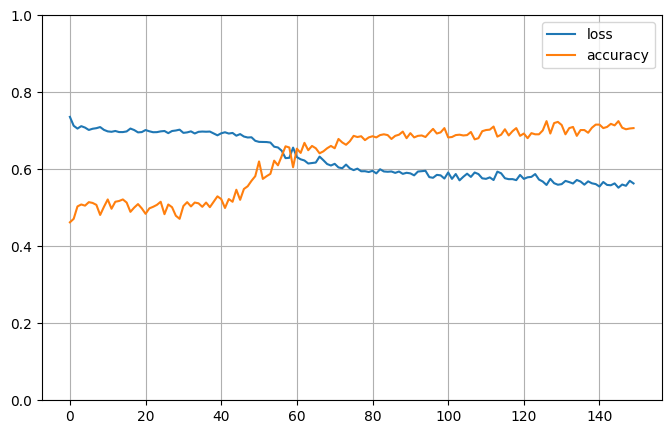

Validate
Num validation samples in this fold: 596 596
Num exclusions: 0
Num validation samples after exclusion: 596 596
Round 1 Fold 2
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2381 2381
Num exclusions: 1388
Num train samples after exclusion: 993 993


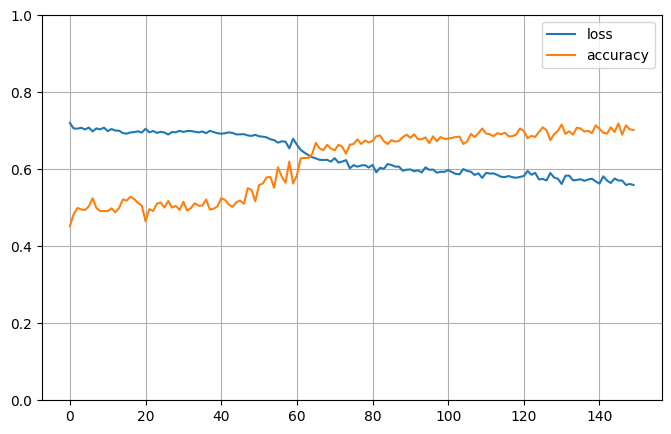

Validate
Num validation samples in this fold: 596 596
Num exclusions: 0
Num validation samples after exclusion: 596 596
Round 1 Fold 3
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2382 2382
Num exclusions: 1363
Num train samples after exclusion: 1019 1019


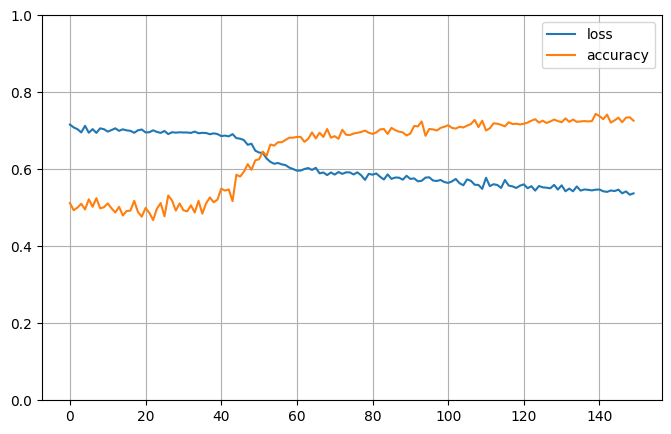

Validate
Num validation samples in this fold: 595 595
Num exclusions: 0
Num validation samples after exclusion: 595 595
Round 1 Fold 4
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2382 2382
Num exclusions: 1352
Num train samples after exclusion: 1030 1030


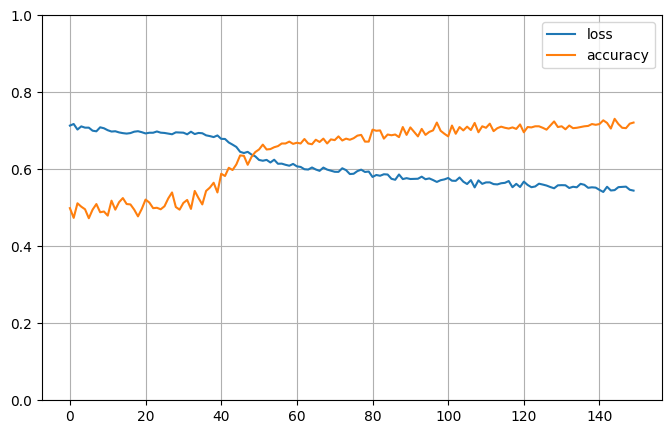

Validate
Num validation samples in this fold: 595 595
Num exclusions: 0
Num validation samples after exclusion: 595 595
Round 1 Fold 5
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2382 2382
Num exclusions: 1357
Num train samples after exclusion: 1025 1025


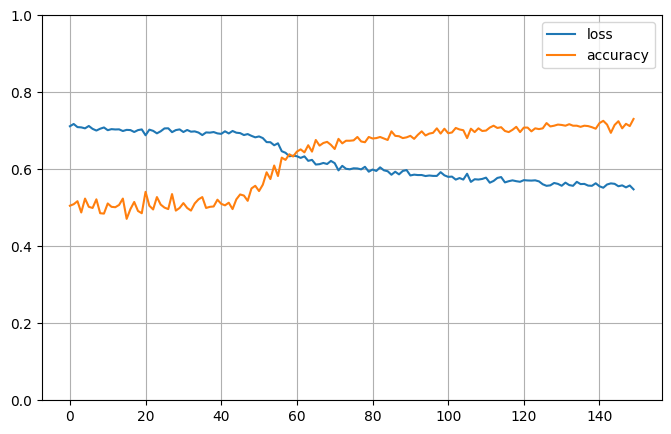

Validate
Num validation samples in this fold: 595 595
Num exclusions: 0
Num validation samples after exclusion: 595 595
Round 2 Fold 1
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2381 2381
Num exclusions: 1388
Num train samples after exclusion: 993 993


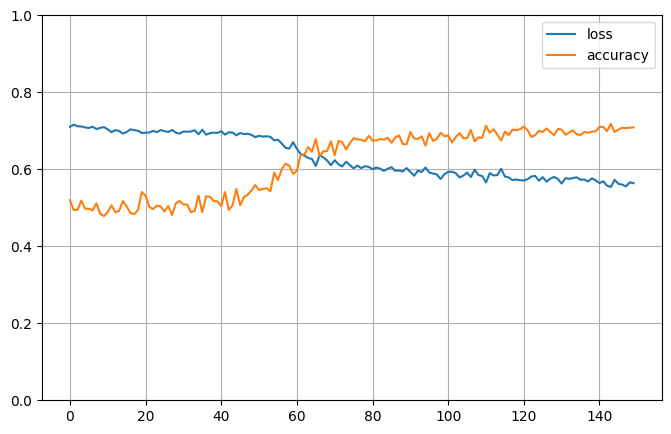

Validate
Num validation samples in this fold: 596 596
Num exclusions: 0
Num validation samples after exclusion: 596 596
Round 2 Fold 2
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2381 2381
Num exclusions: 1388
Num train samples after exclusion: 993 993


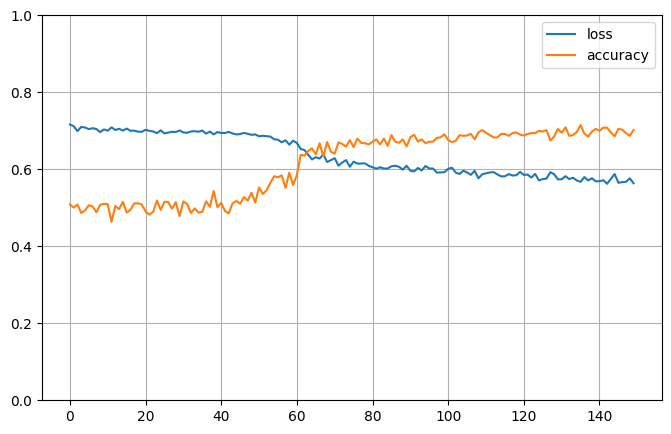

Validate
Num validation samples in this fold: 596 596
Num exclusions: 0
Num validation samples after exclusion: 596 596
Round 2 Fold 3
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2382 2382
Num exclusions: 1363
Num train samples after exclusion: 1019 1019


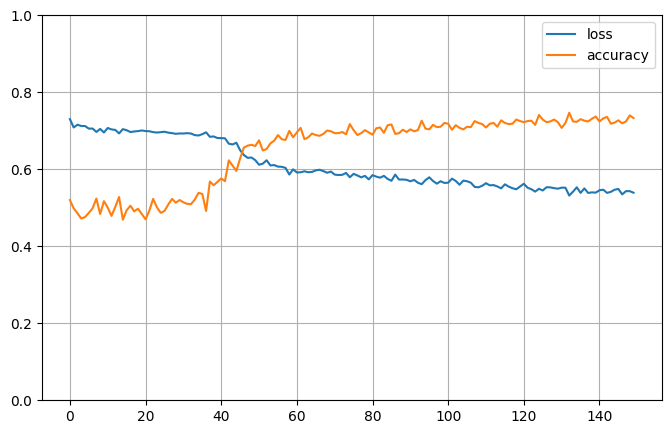

Validate
Num validation samples in this fold: 595 595
Num exclusions: 0
Num validation samples after exclusion: 595 595
Round 2 Fold 4
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2382 2382
Num exclusions: 1352
Num train samples after exclusion: 1030 1030


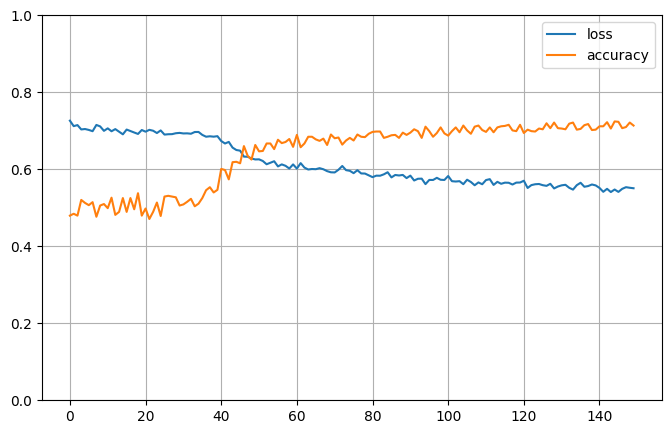

Validate
Num validation samples in this fold: 595 595
Num exclusions: 0
Num validation samples after exclusion: 595 595
Round 2 Fold 5
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2382 2382
Num exclusions: 1357
Num train samples after exclusion: 1025 1025


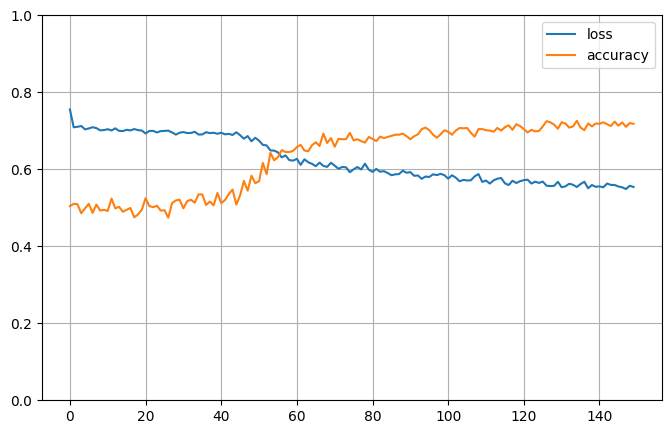

Validate
Num validation samples in this fold: 595 595
Num exclusions: 0
Num validation samples after exclusion: 595 595

Cross validation results
  accuracy 61.71 mean,  0.770 stdev
[62.751677852349, 61.74496644295302, 61.680672268907564, 61.84873949579832, 60.0, 62.41610738255034, 62.248322147651, 61.84873949579832, 61.84873949579832, 60.67226890756302]
 precision 62.24 mean,  2.577 stdev
[63.63636363636363, 59.50920245398773, 66.28787878787878, 59.24657534246576, 62.16216216216216, 62.37288135593221, 60.18808777429467, 66.53992395437263, 59.375, 63.10344827586207]
    recall 60.63 mean,  3.579 stdev
[58.92255892255892, 66.89655172413794, 55.73248407643312, 61.56583629893239, 59.354838709677416, 61.95286195286195, 66.20689655172414, 55.73248407643312, 60.854092526690394, 59.03225806451613]
        F1 61.28 mean,  1.016 stdev
[61.18881118881119, 62.98701298701299, 60.553633217993074, 60.38394415357766, 60.72607260726072, 62.16216216216216, 63.05418719211823, 60.65857885615251, 60.10544

In [33]:
if True:   # middle exclusion on training set only
    print('middle exclusion on training set only')
    cyto_f = DATA_DIR+'ForRNAlight.lncRNA_RCIgt0.canonical.tsv'
    nuc_f  = DATA_DIR+'ForRNAlight.lncRNA_RCIlt-2.canonical.tsv'
    cyto_mid_f = DATA_DIR+'ForRNAlight.lncRNA_RCI-1to0.canonical.tsv'
    nuc_mid_f  = DATA_DIR+'ForRNAlight.lncRNA_RCI-2to-1.canonical.tsv'
    print('Data files:')
    print(cyto_f,'\n',nuc_f)
    print(cyto_mid_f,'\n',nuc_mid_f)
    dataset_cyto,dataset_nuc,middle_cyto,middle_nuc = load_dataframe(cyto_f,nuc_f,cyto_mid_f,nuc_mid_f)
    print('Rebalance (sample down the majority class) and repeat')
    dataset_cyto,dataset_nuc = rebalance(dataset_cyto,dataset_nuc)
    middle_cyto,middle_nuc = rebalance(middle_cyto,middle_nuc)
    x_train, x_test, y_train, y_test = extract_features_and_split(dataset_cyto,dataset_nuc,middle_cyto,middle_nuc)
    stats = do_cv(x_train, y_train, TRAIN_MODE)
    print('\nCross validation results')
    stats.dump_all()

middle exclusion on validation set only
Data files:
/content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.lncRNA_RCIgt0.canonical.tsv 
 /content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.lncRNA_RCIlt-2.canonical.tsv
/content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.lncRNA_RCI-1to0.canonical.tsv 
 /content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.lncRNA_RCI-2to-1.canonical.tsv
load dataframe
1703 cytoplasmic samples
706 nuclear samples
1184 cytoplasmic middle samples
948 nuclear middle samples
Rebalance (sample down the majority class) and repeat
sample down to balance classes
706 cytoplasmic samples
706 nuclear samples
sample down to balance classes
948 cytoplasmic samples
948 nuclear samples
add labels, concatenate
dedupe (probably not necessary)
count kmers
train/test split
train set shape (2977, 1344)
train set labels [-2  0  1  2] counts [850 635 630 862]
test set labels [-2  0  1  2] counts [98 71 76 86]
Round 1 Fold 1
Train
Num sampl

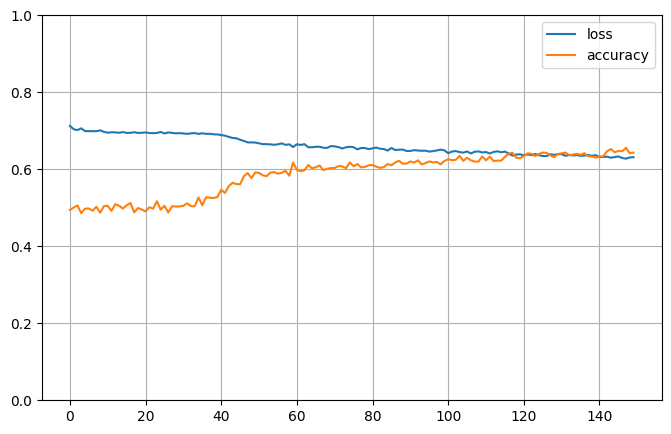

Validate
Num validation samples in this fold: 596 596
Num exclusions: 324
Num validation samples after exclusion: 272 272
Round 1 Fold 2
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2381 2381
Num exclusions: 0
Num train samples after exclusion: 2381 2381


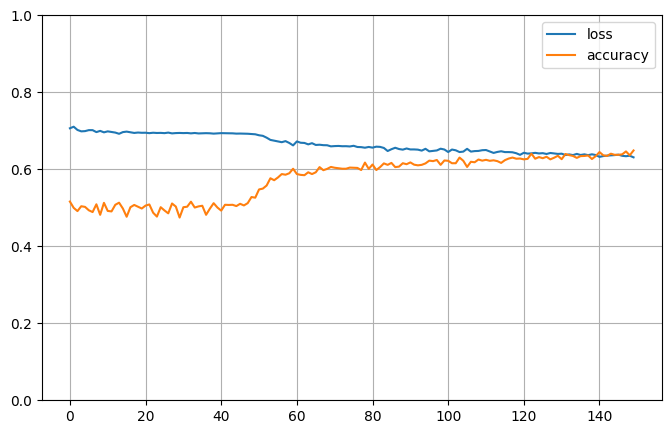

Validate
Num validation samples in this fold: 596 596
Num exclusions: 324
Num validation samples after exclusion: 272 272
Round 1 Fold 3
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2382 2382
Num exclusions: 0
Num train samples after exclusion: 2382 2382


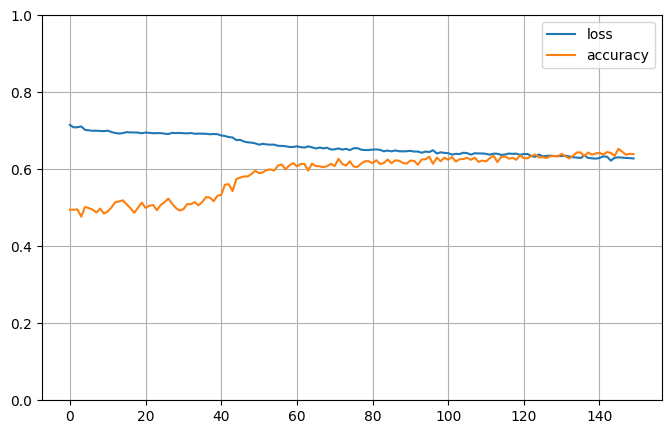

Validate
Num validation samples in this fold: 595 595
Num exclusions: 349
Num validation samples after exclusion: 246 246
Round 1 Fold 4
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2382 2382
Num exclusions: 0
Num train samples after exclusion: 2382 2382


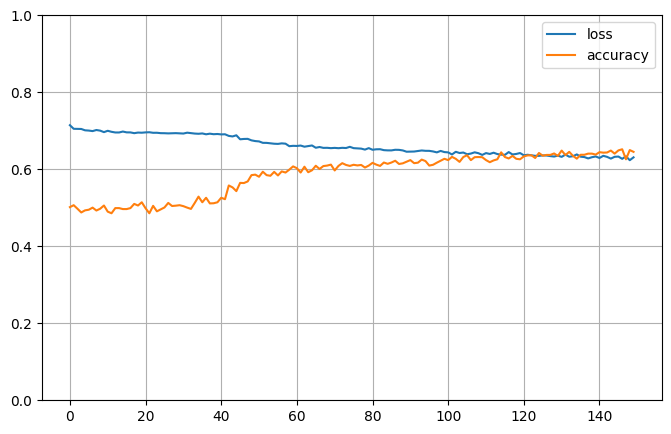

Validate
Num validation samples in this fold: 595 595
Num exclusions: 360
Num validation samples after exclusion: 235 235
Round 1 Fold 5
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2382 2382
Num exclusions: 0
Num train samples after exclusion: 2382 2382


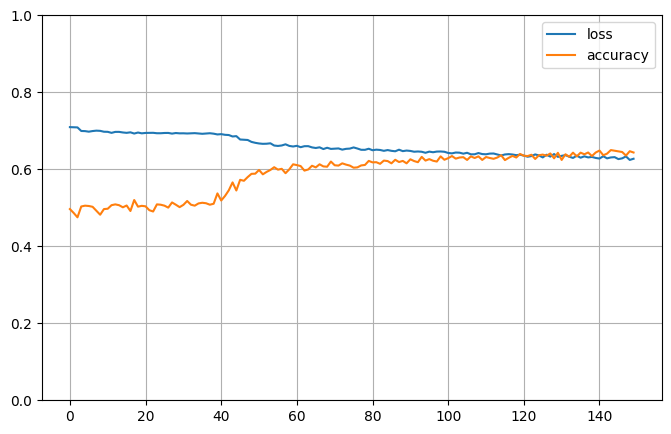

Validate
Num validation samples in this fold: 595 595
Num exclusions: 355
Num validation samples after exclusion: 240 240
Round 2 Fold 1
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2381 2381
Num exclusions: 0
Num train samples after exclusion: 2381 2381


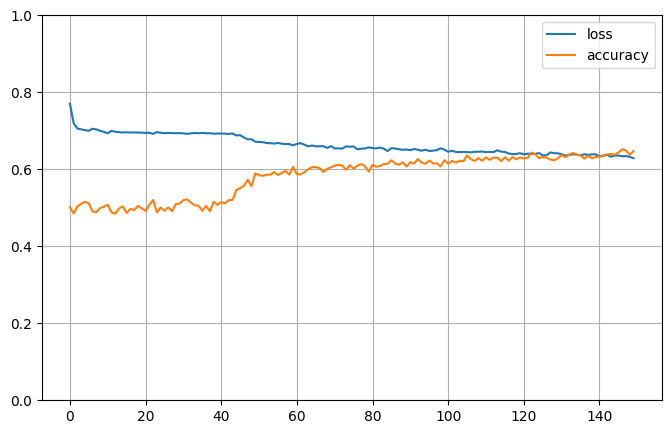

Validate
Num validation samples in this fold: 596 596
Num exclusions: 324
Num validation samples after exclusion: 272 272
Round 2 Fold 2
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2381 2381
Num exclusions: 0
Num train samples after exclusion: 2381 2381


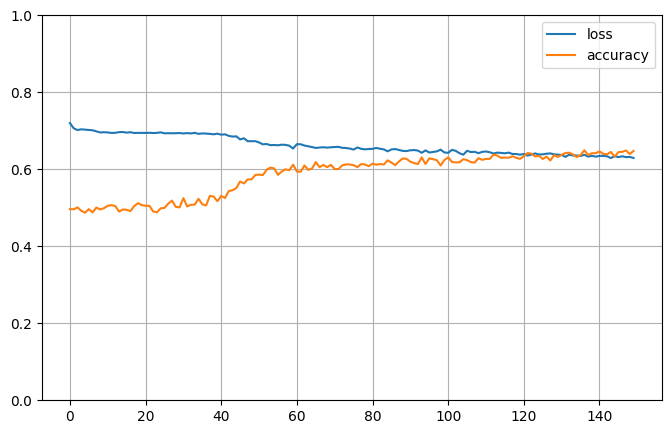

Validate
Num validation samples in this fold: 596 596
Num exclusions: 324
Num validation samples after exclusion: 272 272
Round 2 Fold 3
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2382 2382
Num exclusions: 0
Num train samples after exclusion: 2382 2382


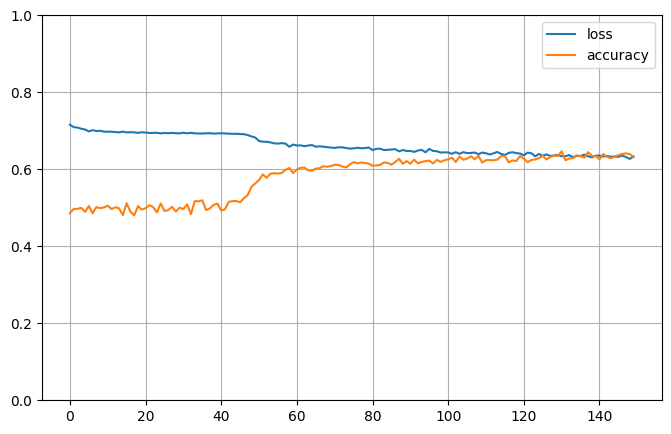

Validate
Num validation samples in this fold: 595 595
Num exclusions: 349
Num validation samples after exclusion: 246 246
Round 2 Fold 4
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2382 2382
Num exclusions: 0
Num train samples after exclusion: 2382 2382


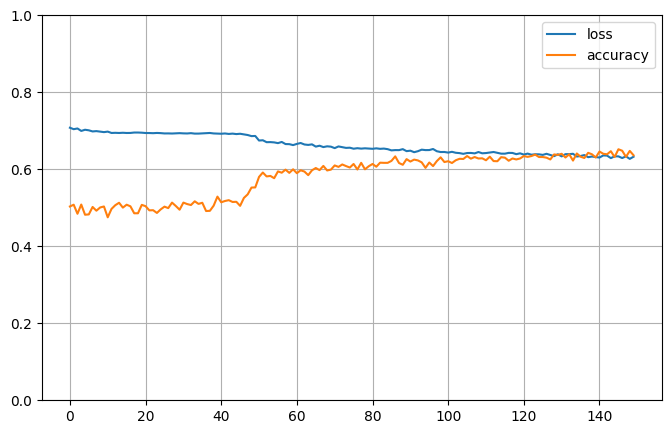

Validate
Num validation samples in this fold: 595 595
Num exclusions: 360
Num validation samples after exclusion: 235 235
Round 2 Fold 5
Train
Num samples in training set: 2977 2977
Num train samples in this fold: 2382 2382
Num exclusions: 0
Num train samples after exclusion: 2382 2382


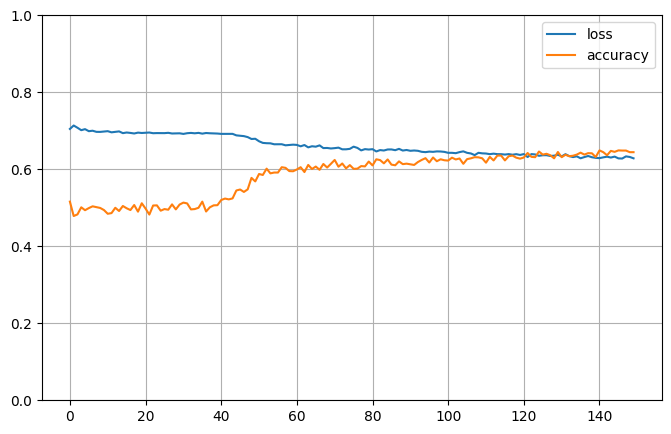

Validate
Num validation samples in this fold: 595 595
Num exclusions: 355
Num validation samples after exclusion: 240 240

Cross validation results
  accuracy 70.88 mean,  2.491 stdev
[68.75, 73.52941176470588, 69.51219512195121, 74.04255319148936, 68.33333333333333, 68.75, 73.52941176470588, 68.69918699186992, 74.46808510638297, 69.16666666666667]
 precision 71.25 mean,  3.717 stdev
[66.66666666666666, 69.93006993006993, 73.27586206896551, 78.21782178217822, 68.18181818181817, 67.17557251908397, 70.2127659574468, 72.41379310344827, 76.85185185185185, 69.53125]
    recall 70.38 mean,  4.080 stdev
[69.23076923076923, 77.51937984496125, 65.89147286821705, 66.94915254237289, 72.58064516129032, 67.6923076923077, 76.74418604651163, 65.11627906976744, 70.33898305084746, 71.7741935483871]
        F1 70.67 mean,  2.222 stdev
[67.9245283018868, 73.5294117647059, 69.38775510204081, 72.14611872146119, 70.3125, 67.43295019157088, 73.33333333333334, 68.57142857142857, 73.45132743362832, 70.63492063

In [34]:
if True:   # middle exclusion on validation set only
    print('middle exclusion on validation set only')
    cyto_f = DATA_DIR+'ForRNAlight.lncRNA_RCIgt0.canonical.tsv'
    nuc_f  = DATA_DIR+'ForRNAlight.lncRNA_RCIlt-2.canonical.tsv'
    cyto_mid_f = DATA_DIR+'ForRNAlight.lncRNA_RCI-1to0.canonical.tsv'
    nuc_mid_f  = DATA_DIR+'ForRNAlight.lncRNA_RCI-2to-1.canonical.tsv'
    print('Data files:')
    print(cyto_f,'\n',nuc_f)
    print(cyto_mid_f,'\n',nuc_mid_f)
    dataset_cyto,dataset_nuc,middle_cyto,middle_nuc = load_dataframe(cyto_f,nuc_f,cyto_mid_f,nuc_mid_f)
    print('Rebalance (sample down the majority class) and repeat')
    dataset_cyto,dataset_nuc = rebalance(dataset_cyto,dataset_nuc)
    middle_cyto,middle_nuc = rebalance(middle_cyto,middle_nuc)
    x_train, x_test, y_train, y_test = extract_features_and_split(dataset_cyto,dataset_nuc,middle_cyto,middle_nuc)
    stats = do_cv(x_train, y_train, VALID_MODE)
    print('\nCross validation results')
    stats.dump_all()

In [35]:
print(datetime.now())
print('Done')

2024-03-21 20:55:02.009408
Done
